In [1]:
from transformers import AutoImageProcessor, AutoFeatureExtractor, TrOCRProcessor, VisionEncoderDecoderModel, DefaultDataCollator
import requests
from PIL import Image
import torch
from pathlib import Path
from datasets import Dataset, load_dataset
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, ToPILImage
from matplotlib import pyplot as plt
import evaluate
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer




# Define ids for target labels

In [23]:
labels = ['male', 'female', 'diverse']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label]      = i
    id2label[i]     = label

print(label2id, id2label)

{'male': 0, 'female': 1, 'diverse': 2} {0: 'male', 1: 'female', 2: 'diverse'}


# Load test image(s) and create dataset

In [36]:
IMAGES = '/home/jv/Bilder/words/'
images_path = Path(IMAGES)

images_labels = { '001': 'male',
                  '009': 'male',
                  '20' : 'female',
                  '38' : 'female',
                  '54' : 'female'}

all_images = []
for idx, label in images_labels.items():
    for img_path in (images_path / idx).glob('*.JPG'):
        all_images.append({ 'label': label, 'path': img_path })

# _generator = ({'label': l['label'], 'image': Image.open(l['path'])} for l in all_images) 
#ds = Dataset.from_generator(_generator)
def _generator():
    for l in all_images:
        yield {'label': label2id[l['label']], 
               'image': Image.open(l['path'])}

ds=Dataset.from_generator(_generator)
ds = ds.train_test_split(test_size=0.2)

Generating train split: 0 examples [00:00, ? examples/s]

In [37]:
list(_generator())

[{'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=156x132>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=174x100>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=254x138>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=140x116>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=144x114>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=346x130>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=152x104>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=324x140>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x108>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=236x152>},
 {'label': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=194x112>},

In [38]:
label2id[ds['train'][0]['label']]

KeyError: 1

# Preprocess image

In [39]:
# Load Processor for ViT
#CHECKPOINT="microsoft/trocr-base-handwritten"
#CHECKPOINT="google/vit-base-patch16-384"
CHECKPOINT="google/vit-base-patch16-224-in21k"
# Alternative: TrOCRProcessor.from_pretrained(CHECKPOINT).image_processor
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

In [40]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

(224, 224)


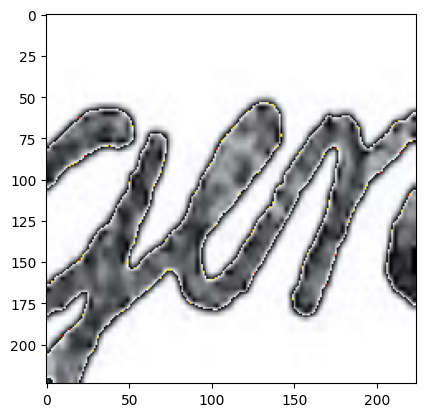

In [54]:
# Normalize Input Image
# evtl. use processor(img), but this returns an object with different dimensions
def tensor_to_image(t) -> Image:
    transform=ToPILImage()
    return transform(t)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
# in other processors, maybe use 'shortest_edge'
size = ( processor.size["height"], processor.size["width"] )
# JV suggests: do not normalize bc these are no food images
#_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])
#_transforms = Compose([Resize(size), ToTensor(), normalize])
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

print(size)
def transforms(examples):
    """Transform the image in the Dataset row."""
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

ds = ds.with_transform(transforms)
tensor = ds['train'][0]['pixel_values']

img = tensor_to_image(tensor)
plt.imshow(img)
plt.show()

In [55]:
ds['train'][0:2]

{'label': [1, 1],
 'pixel_values': [tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]),
  tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
    

In [56]:
data_collator = DefaultDataCollator()
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # highest prediction per label index
    return accuracy.compute(predictions=predictions, references=labels)


In [57]:
id2label, label2id

({0: 'male', 1: 'female', 2: 'diverse'},
 {'male': 0, 'female': 1, 'diverse': 2})

In [58]:
model = AutoModelForImageClassification.from_pretrained(
    CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
training_args = TrainingArguments(
    output_dir="./local_checkpoints/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0086642503738403, 'eval_accuracy': 0.7096774193548387, 'eval_runtime': 2.5958, 'eval_samples_per_second': 11.943, 'eval_steps_per_second': 0.77, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8364988565444946, 'eval_accuracy': 0.8387096774193549, 'eval_runtime': 2.6134, 'eval_samples_per_second': 11.862, 'eval_steps_per_second': 0.765, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7897107601165771, 'eval_accuracy': 0.8387096774193549, 'eval_runtime': 2.6778, 'eval_samples_per_second': 11.577, 'eval_steps_per_second': 0.747, 'epoch': 3.0}
{'train_runtime': 99.7822, 'train_samples_per_second': 3.668, 'train_steps_per_second': 0.06, 'train_loss': 0.9753514130910238, 'epoch': 3.0}


TrainOutput(global_step=6, training_loss=0.9753514130910238, metrics={'train_runtime': 99.7822, 'train_samples_per_second': 3.668, 'train_steps_per_second': 0.06, 'train_loss': 0.9753514130910238, 'epoch': 3.0})

In [80]:
from transformers import pipeline
import random

classifier = pipeline("image-classification", model=model, image_processor=processor)
males = [ l['path'] for  l in random.sample(all_images, len(all_images)) if l['label'] == 'male' ][:20]
for img in males:
    print(classifier(Image.open(img)))

[{'score': 0.4327056407928467, 'label': 'female'}, {'score': 0.33303430676460266, 'label': 'male'}, {'score': 0.23426005244255066, 'label': 'diverse'}]
[{'score': 0.4283634126186371, 'label': 'female'}, {'score': 0.3555068075656891, 'label': 'male'}, {'score': 0.21612977981567383, 'label': 'diverse'}]
[{'score': 0.41298210620880127, 'label': 'female'}, {'score': 0.3653598725795746, 'label': 'male'}, {'score': 0.22165808081626892, 'label': 'diverse'}]
[{'score': 0.4450558125972748, 'label': 'female'}, {'score': 0.34937363862991333, 'label': 'male'}, {'score': 0.20557048916816711, 'label': 'diverse'}]
[{'score': 0.43007519841194153, 'label': 'female'}, {'score': 0.32953861355781555, 'label': 'male'}, {'score': 0.2403862327337265, 'label': 'diverse'}]
[{'score': 0.392875999212265, 'label': 'female'}, {'score': 0.34145209193229675, 'label': 'male'}, {'score': 0.2656719386577606, 'label': 'diverse'}]
[{'score': 0.41850459575653076, 'label': 'female'}, {'score': 0.35999152064323425, 'label':